In [38]:
# Standard libraries
import numpy as np
import pandas as pd
import warnings
import zipfile, io

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick

# Statistical libraries
import scipy.stats as ss
from scipy import stats
from scipy.stats import f_oneway
from scipy.sparse import csr_matrix

# Scikit-learn preprocessing and model selection
from sklearn.impute import KNNImputer
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score

# Scikit-learn feature selection
from sklearn.feature_selection import f_classif, SelectKBest, mutual_info_classif, RFE, RFECV

# Scikit-learn models
from sklearn.linear_model import LogisticRegression, LassoCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

# Scikit-learn metrics
from sklearn.metrics import make_scorer, precision_score, recall_score, f1_score, classification_report

# Pickle for import and export of datasets
import pickle

# Seaborn settings
sns.set()

# Ignore warnings
warnings.filterwarnings('ignore')

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

In [39]:
X_train_encoded = pd.read_csv('datasets/scaled_data_train_delivery1.csv', index_col=0)
y_train_encoded = pd.read_csv('datasets/scaled_target_train_delivery1.csv', index_col=0)
X_test_encoded = pd.read_csv('datasets/scaled_data_test_delivery1.csv', index_col=0)

In [40]:
numeric_features = ['Age at Injury', 'Average Weekly Wage', 'Birth Year','Number of Dependents', 'Accident Year', 'Accident Month', 'Assembly Year','Assembly Month']
                    
categorical_features = ['Carrier Name', 'Carrier Type', 'County of Injury','District Name', 'Industry Code', 'Industry Code Description', 'Medical Fee Region',
                        'WCIO Cause of Injury Code', 'WCIO Cause of Injury Description',
                        'WCIO Nature of Injury Code', 'WCIO Nature of Injury Description', 'Age Group',
                        'WCIO Part Of Body Code', 'WCIO Part Of Body Description', 'Zip Code', 'Broad Body Part']
                        
binary_features = ['Alternative Dispute Resolution', 'Attorney/Representative','C-2 Date', 'C-3 Date', 'COVID-19 Indicator','Gender', 'Accident on Weekday','Frequent Injury Cause']

In [41]:
# Check variance of the scaled numerical features
# Split into numeric and categorical (training and test sets)
X_train_numeric_scaled = X_train_encoded[numeric_features]
X_train_categorical_encoded = X_train_encoded.drop(columns=numeric_features)

X_test_numeric_scaled = X_test_encoded[numeric_features]
X_test_categorical_encoded = X_test_encoded.drop(columns=numeric_features)

# 4. Feature Selection

## Numerical

## **4.1 Filter Methods**

### **4.1.1. Univariate variables**

### **4.1.2 Correlation Indices**

In [42]:
# function the plot spearman correlation matrix

def cor_heatmap(cor):
    plt.figure(figsize=(12,10))
    sns.heatmap(data = cor, annot = True, cmap = plt.cm.Reds, fmt='.1')
    plt.show()

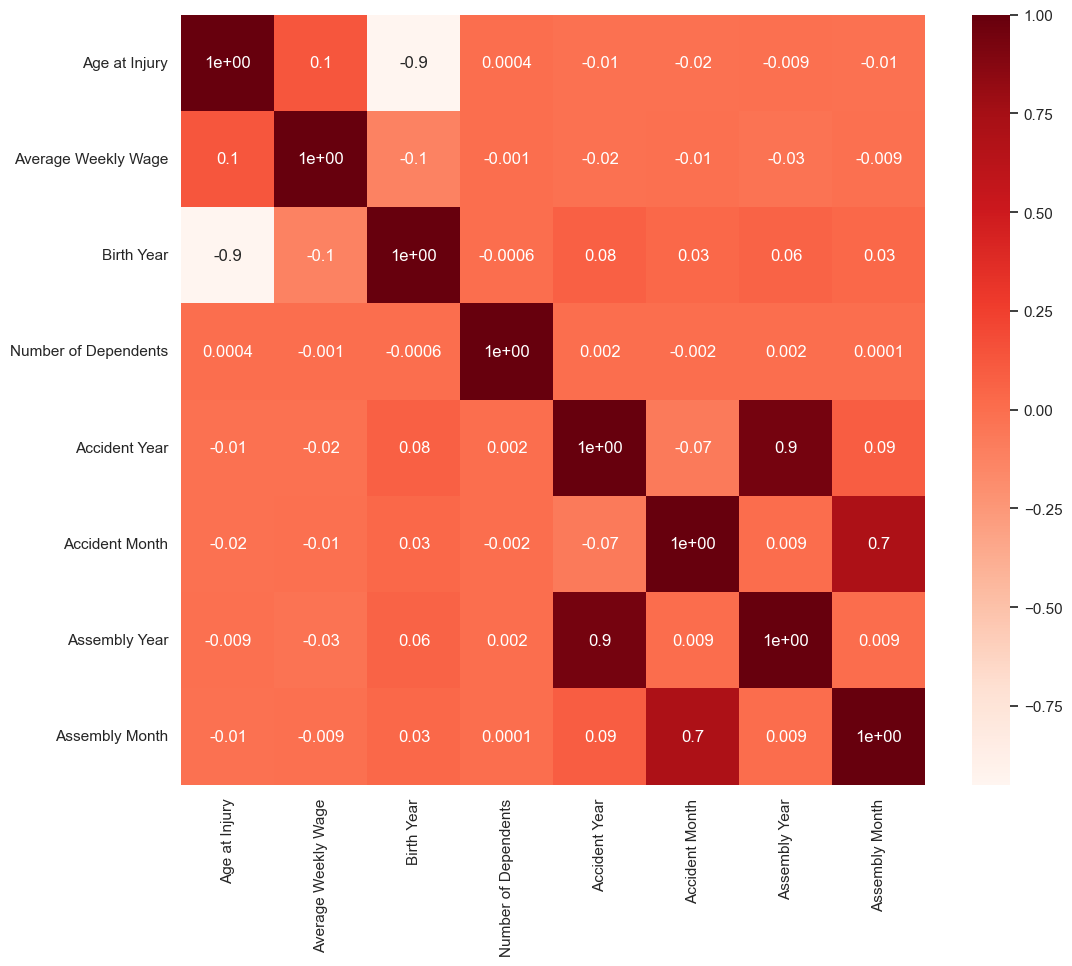

In [43]:
# get the spearman correlation matrix
corr_spearman = X_train_numeric_scaled.corr(method='spearman')
cor_heatmap(corr_spearman)

## 4.2. Wrapper Methods

### 4.2.1. RFE

#### **4.2.1.1 RFE - Logistic Regression**

In [44]:
# Initialize the Logistic Regression model for RFE-Logistic Regression
model_LR = LogisticRegression()

# Initialize the Recursive Feature Elimination (RFE) selector
rfe_LR = RFE(estimator = model_LR, n_features_to_select = 3)

# Fit the RFE selector to the training data
X_rfe = rfe_LR.fit_transform(X = X_train_numeric_scaled, y = y_train_encoded)

# Get the selected features
rfelr_selected = X_train_numeric_scaled.columns[rfe_LR.support_]

In [45]:
rfelr_selected

Index(['Average Weekly Wage', 'Birth Year', 'Accident Year'], dtype='object')

#### **4.2.1.2. RFE - Cross-Validation**

In [46]:
# Initialize the Logistic Regression model for RFE-Cross-Validation
model_CV = LogisticRegression()

# Define StratifiedKFold (stratified K-Folds cross-validator) with 5 splits
cv_strategy = StratifiedKFold(n_splits=5) 

# Perform Recursive Feature Elimination with Cross-Validation (RFE-CV)
rfecv = RFECV(estimator=model_CV, step=1, cv=cv_strategy, scoring='accuracy')  

# Fit RFE-CV on the training data
rfecv.fit(X_train_numeric_scaled, y_train_encoded)

# Optimal score
optimal_score = max(rfecv.cv_results_['mean_test_score'])

# Optimal number of features
print("Optimal number of features: %d" % rfecv.n_features_)

# Optimal performance
print("Score with %d features: %f" % (rfecv.n_features_, optimal_score))

Optimal number of features: 1
Score with 1 features: 0.713728


In [47]:
# Print the ranking of features
# Features with a rank of 1 are the most important features selected by the RFE-CV process and higher ranks are less important
print("Feature ranking:", rfecv.ranking_)

Feature ranking: [6 1 3 8 2 7 4 5]


In [48]:
# Create a DataFrame with the support and ranking of features
rfecv_selected = pd.DataFrame({"support": rfecv.support_, "ranking": rfecv.ranking_}, index=X_train_numeric_scaled.columns)

# Filter the DataFrame to get only the features with a rank of 1
important_features = rfecv_selected[rfecv_selected['ranking'] == 1]

# Print the important features
print("Important features selected by RFECV:")
print(important_features)

Important features selected by RFECV:
                     support  ranking
Average Weekly Wage     True        1


## 4.3 Embedded Methods

### **4.3.1 Lasso Regression**

In [49]:
# Initialize the Lasso model 
reg = LassoCV()

# Fit the Lasso model to the training data
reg.fit(X_train_numeric_scaled, y_train_encoded)

LassoCV()

In [50]:
# Get the coefficients of the Lasso model
coef = pd.Series(reg.coef_, index = X_train_numeric_scaled.columns)
coef

Age at Injury           0.000000
Average Weekly Wage     2.642469
Birth Year             -0.009661
Number of Dependents    0.000000
Accident Year          -0.000000
Accident Month         -0.000000
Assembly Year          -0.120393
Assembly Month         -0.043063
dtype: float64

In [51]:
# Sort the coefficients by their absolute values
sorted_coef = coef.abs().sort_values(ascending=False)

In [52]:
# Function to plot feature importance according to Lasso
def plot_importance(coef,name):
    imp_coef = coef.sort_values()
    plt.figure(figsize=(8,10))
    imp_coef.plot(kind = "barh")
    plt.title("Feature importance using " + name + " Model")
    plt.show()

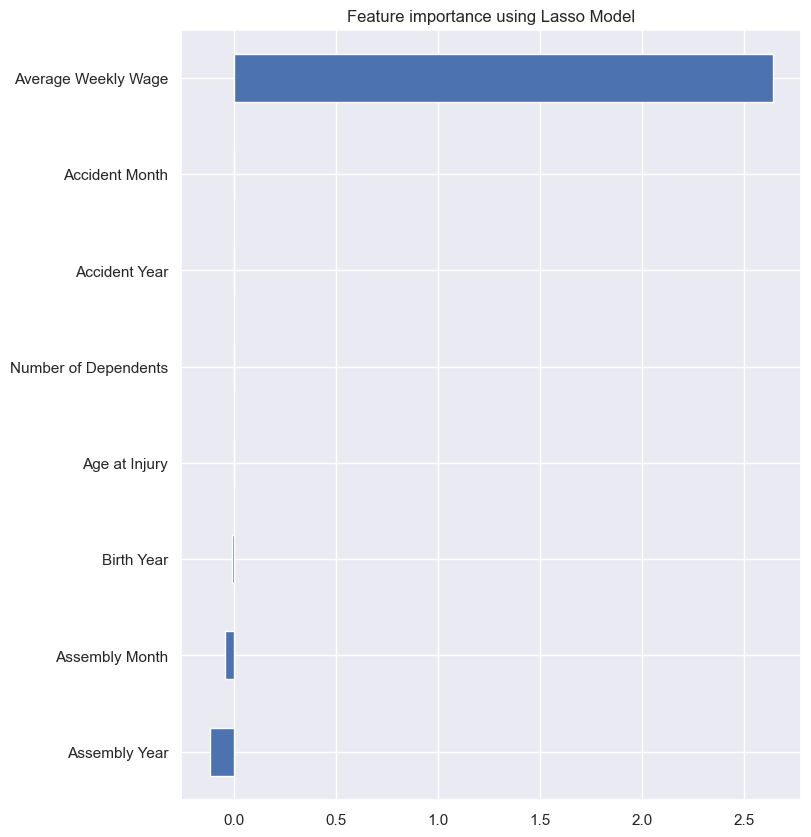

In [53]:
plot_importance(coef,'Lasso')

Keeping the 4 features with the highest absolute value for the Lasso Model.

### **4.3.2 Decision Tree**

In [54]:
# Initialize and train a Decision Tree classifier

tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train_numeric_scaled, y_train_encoded)

DecisionTreeClassifier(random_state=42)

In [55]:
# Get feature importances
importances = tree_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)

                Feature  Importance
1   Average Weekly Wage    0.602799
0         Age at Injury    0.094297
3  Number of Dependents    0.091527
2            Birth Year    0.081835
7        Assembly Month    0.055337
5        Accident Month    0.052699
4         Accident Year    0.014321
6         Assembly Year    0.007185


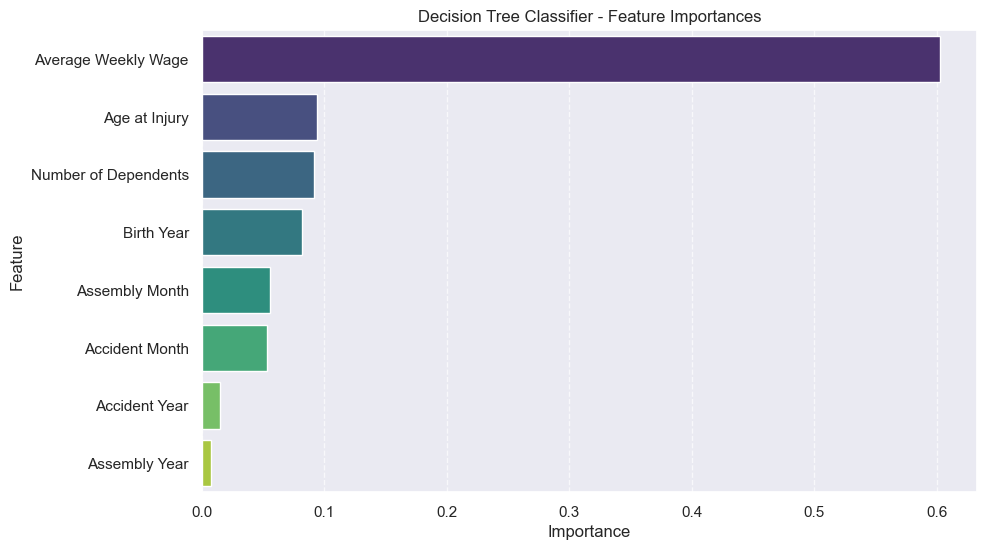

In [56]:
# Ensure 'feature_importances' DataFrame is correctly defined
feature_importances = pd.DataFrame({
	'Feature': X_train_numeric_scaled.columns,
	'Importance': tree_model.feature_importances_
}).sort_values(by='Importance', ascending=False)

# Plot the feature importances
plt.figure(figsize=(10, 6))
sns.barplot(data=feature_importances, x='Importance', y='Feature', palette='viridis')
plt.title('Decision Tree Classifier - Feature Importances')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()


Keeping the 2 features with the highest importance value. The other features have under than 0.1 importance value.

### **4.3.3 Gradient Boosting**

In [57]:
gb_model = GradientBoostingClassifier(random_state=42)
gb_model.fit(X_train_numeric_scaled, y_train_encoded)

# Get feature importances
importances = gb_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances)


                Feature  Importance
1   Average Weekly Wage    0.974259
4         Accident Year    0.016071
0         Age at Injury    0.003004
5        Accident Month    0.002452
7        Assembly Month    0.002243
6         Assembly Year    0.001172
2            Birth Year    0.000759
3  Number of Dependents    0.000040


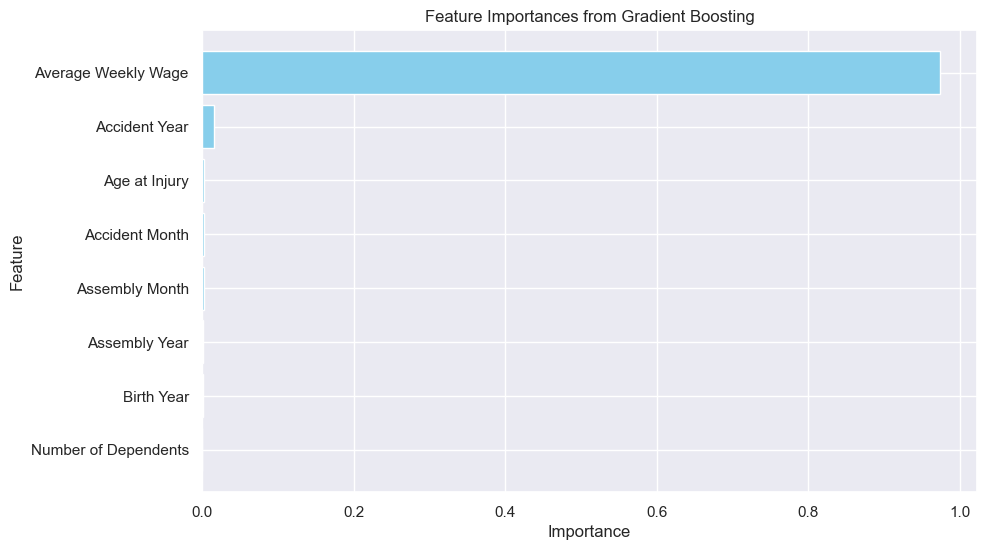

In [58]:
# Plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances['Feature'], feature_importances['Importance'], color='skyblue')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Gradient Boosting')
plt.gca().invert_yaxis()  # Reverse the y-axis so the most important feature is at the top
plt.show()


Keeping only the highest important feature with more than 0.8 of importance value. The other features are under 0.1 which is a big gap.

Keeping the 4 features above the 20000 treshold. 

### **4.3.5 Random Forest**

In [59]:
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train_numeric_scaled, y_train_encoded)

# Get feature importances
importances = rf_model.feature_importances_

# Create a DataFrame for better visualization
feature_importances_rf = pd.DataFrame({
    'Feature': X_train_numeric_scaled.columns,
    'Importance': importances
})

# Sort features by importance
feature_importances_rf = feature_importances_rf.sort_values(by='Importance', ascending=False)

# Display feature importances
print(feature_importances_rf)

                Feature  Importance
1   Average Weekly Wage    0.594262
0         Age at Injury    0.100073
3  Number of Dependents    0.087480
2            Birth Year    0.085996
7        Assembly Month    0.059962
5        Accident Month    0.058557
4         Accident Year    0.009237
6         Assembly Year    0.004433


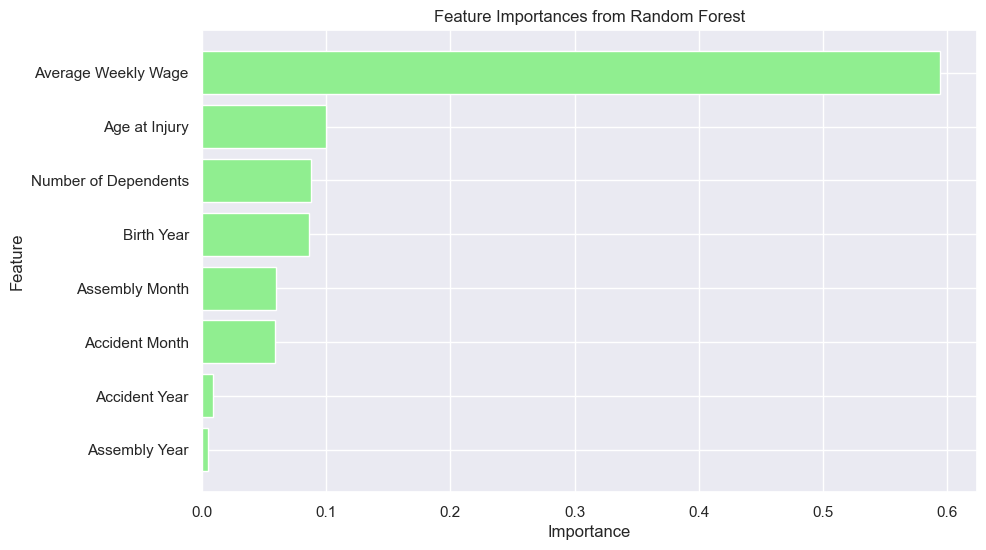

In [60]:
# plot feature importances
plt.figure(figsize=(10, 6))
plt.barh(feature_importances_rf['Feature'], feature_importances_rf['Importance'], color='lightgreen')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Feature Importances from Random Forest')
plt.gca().invert_yaxis()  # reverse the y-axis so that the most important feature is at the top
plt.show()


Keeping the 2 features with the highest importance value. The others are under 0.1, too close to 0 considering one of the features got almost 0.35


## Categorical

### **4.3.6 Chi Square**

In [61]:
# List to store chi-square test results
chi2_results = []

def TestIndependence(X, y, var, alpha=0.01):
    # Create a contingency table (observed frequencies)
    dfObserved = pd.crosstab(y, X)

    # Perform the chi-square test of independence
    chi2, p, dof, expected = stats.chi2_contingency(dfObserved.values)

    # Determine the importance based on the p-value
    if p < alpha:
        importance = "Important"
    else:
        importance = "Not Important"

    # Append the results to the chi2_results list
    chi2_results.append({
        'Feature': var,
        'Chi-Square Score': chi2,
        'Importance': importance
    })

    # Print the result for the feature
    print(f"{var} is {importance} for Prediction")


In [62]:
# Loop through each categorical feature in the training data
for var in X_train_categorical_encoded.columns:
    # Perform the chi-square test of independence for the current feature
    TestIndependence(X_train_categorical_encoded[var], y_train_encoded.values.ravel(), var)

Carrier Type_2A. SIF is Important for Prediction
Carrier Type_3A. SELF PUBLIC is Important for Prediction
Carrier Type_4A. SELF PRIVATE is Important for Prediction
Carrier Type_5A. SPECIAL FUND - CONS. COMM. (SECT. 25-A) is Important for Prediction
Carrier Type_5C. SPECIAL FUND - POI CARRIER WCB MENANDS is Not Important for Prediction
Carrier Type_5D. SPECIAL FUND - UNKNOWN is Important for Prediction
Carrier Type_UNKNOWN is Important for Prediction
County of Injury_ALLEGANY is Important for Prediction
County of Injury_BRONX is Important for Prediction
County of Injury_BROOME is Important for Prediction
County of Injury_CATTARAUGUS is Not Important for Prediction
County of Injury_CAYUGA is Important for Prediction
County of Injury_CHAUTAUQUA is Important for Prediction
County of Injury_CHEMUNG is Important for Prediction
County of Injury_CHENANGO is Important for Prediction
County of Injury_CLINTON is Important for Prediction
County of Injury_COLUMBIA is Important for Prediction
County

In [63]:
# Convert the list of chi-square test results to a DataFrame
chi2_df = pd.DataFrame(chi2_results).sort_values(by='Chi-Square Score', ascending=False)

# Print the DataFrame containing the chi-square test results
print(chi2_df)

                             Feature  Chi-Square Score     Importance
299          Attorney/Representative     200276.455939      Important
301                         C-3 Date     120849.919900      Important
300                         C-2 Date     113869.458751      Important
266      WCIO Part Of Body Code_42.0      25145.115563      Important
98                Industry Code_92.0      21934.730382      Important
..                               ...               ...            ...
226  WCIO Nature of Injury Code_76.0          2.904692  Not Important
213  WCIO Nature of Injury Code_63.0          2.856835  Not Important
212  WCIO Nature of Injury Code_62.0          2.798530  Not Important
131   WCIO Cause of Injury Code_40.0          2.765744  Not Important
229  WCIO Nature of Injury Code_79.0          2.479665  Not Important

[306 rows x 3 columns]


In [64]:
#Check the value counts of the 'Important' features

important_categorical_features = chi2_df[chi2_df['Importance'] == 'Important']['Feature']

print(important_categorical_features)

299            Attorney/Representative
301                           C-3 Date
300                           C-2 Date
266        WCIO Part Of Body Code_42.0
98                  Industry Code_92.0
                    ...               
27           County of Injury_HERKIMER
251        WCIO Part Of Body Code_24.0
208    WCIO Nature of Injury Code_58.0
32            County of Injury_MADISON
54             County of Injury_SENECA
Name: Feature, Length: 275, dtype: object


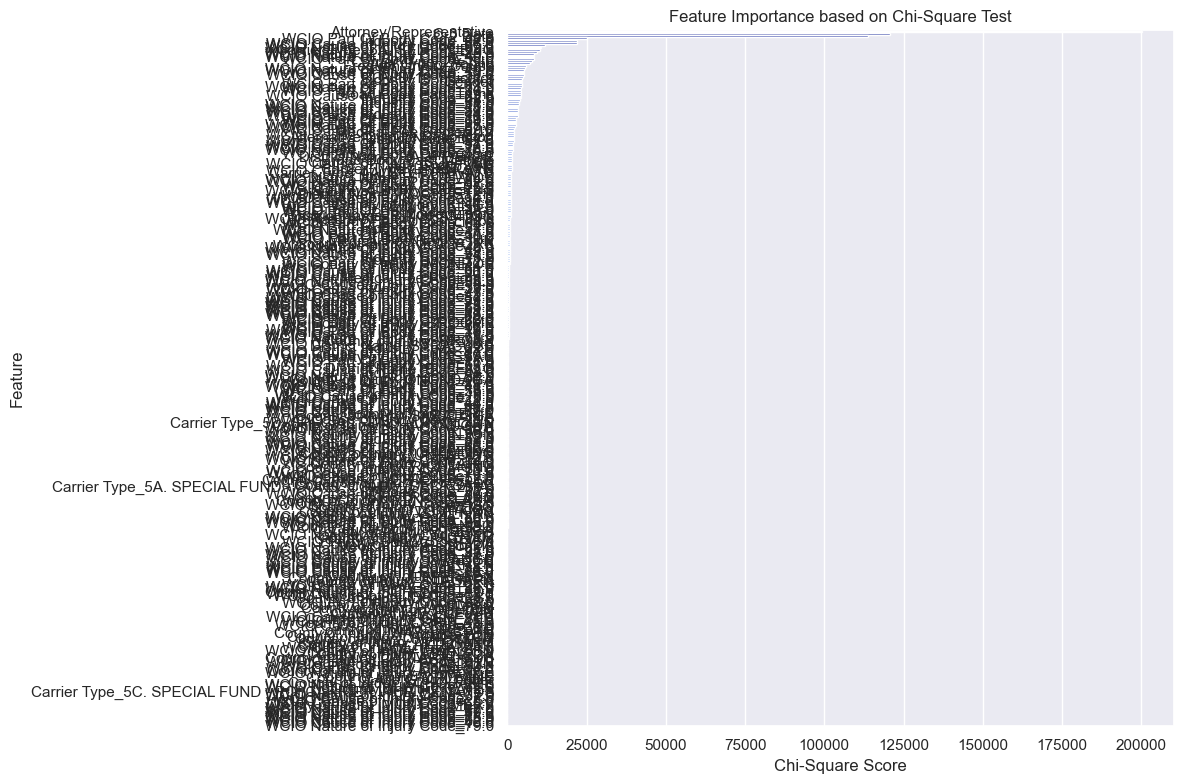

In [65]:
plt.figure(figsize=(12, 8))
sns.barplot(x='Chi-Square Score', y='Feature', data=chi2_df, palette='coolwarm')
plt.title("Feature Importance based on Chi-Square Test")
plt.xlabel("Chi-Square Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()

Keeping the first 5 most important features.
Even though that all 3 WCI0 are highly correlated.

### **4.3.7 Mutual Information**

In [66]:
'''# Convert data to sparse matrix to save memory
X_train_sparse = csr_matrix(X_train_categorical_encoded)

# Perform Mutual Information feature selection
K = 'all'  # Set to an integer if you want to select the top-K features
selector = SelectKBest(score_func=mutual_info_classif, k=K)
X_train_selected = selector.fit_transform(X_train_sparse, y_train)

# Get the scores for each feature
mi_scores = selector.scores_

# Create a DataFrame for better visualization
feature_scores_mi = pd.DataFrame({
    'Feature': X_train_categorical_encoded.columns,
    'Mutual Information Score': mi_scores
})

# Sort features by their Mutual Information score
feature_scores_mi = feature_scores_mi.sort_values(by='Mutual Information Score', ascending=False)

# Display feature scores
print(feature_scores_mi)
'''

"# Convert data to sparse matrix to save memory\nX_train_sparse = csr_matrix(X_train_categorical_encoded)\n\n# Perform Mutual Information feature selection\nK = 'all'  # Set to an integer if you want to select the top-K features\nselector = SelectKBest(score_func=mutual_info_classif, k=K)\nX_train_selected = selector.fit_transform(X_train_sparse, y_train)\n\n# Get the scores for each feature\nmi_scores = selector.scores_\n\n# Create a DataFrame for better visualization\nfeature_scores_mi = pd.DataFrame({\n    'Feature': X_train_categorical_encoded.columns,\n    'Mutual Information Score': mi_scores\n})\n\n# Sort features by their Mutual Information score\nfeature_scores_mi = feature_scores_mi.sort_values(by='Mutual Information Score', ascending=False)\n\n# Display feature scores\nprint(feature_scores_mi)\n"

In [67]:
'''# plot the mutual information scores
plt.figure(figsize=(12, 8))
sns.barplot(x='Mutual Information Score', y='Feature', data=feature_scores_mi, palette='coolwarm')
plt.title("Feature Importance based on Mutual Information Score")
plt.xlabel("Mutual Information Score")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
'''

'# plot the mutual information scores\nplt.figure(figsize=(12, 8))\nsns.barplot(x=\'Mutual Information Score\', y=\'Feature\', data=feature_scores_mi, palette=\'coolwarm\')\nplt.title("Feature Importance based on Mutual Information Score")\nplt.xlabel("Mutual Information Score")\nplt.ylabel("Feature")\nplt.tight_layout()\nplt.show()\n'

Keeping the 4 features with highest Mutual Information Score, because the others are approaching 0.

### **4.3.8 LASSO**

In [68]:
'''
# Convert the data to a sparse format
X_train_sparse = csr_matrix(X_train_categorical_encoded)

# Initialize and train the model with sparse data
lasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)
lasso_model.fit(X_train_sparse, y_train)

# Extract non-zero coefficients for feature selection
coef_lasso = lasso_model.coef_[0]

# Create a DataFrame to store feature importances
feature_importances_lasso = pd.DataFrame({
    'Feature': X_train_categorical.columns,
    'Coefficient': coef_lasso
})

print(feature_importances_lasso.sort_values(by='Coefficient', ascending=False))
'''

"\n# Convert the data to a sparse format\nX_train_sparse = csr_matrix(X_train_categorical_encoded)\n\n# Initialize and train the model with sparse data\nlasso_model = LogisticRegression(penalty='l1', solver='liblinear', random_state=42)\nlasso_model.fit(X_train_sparse, y_train)\n\n# Extract non-zero coefficients for feature selection\ncoef_lasso = lasso_model.coef_[0]\n\n# Create a DataFrame to store feature importances\nfeature_importances_lasso = pd.DataFrame({\n    'Feature': X_train_categorical.columns,\n    'Coefficient': coef_lasso\n})\n\nprint(feature_importances_lasso.sort_values(by='Coefficient', ascending=False))\n"

In [69]:
'''
# plot the feature importance
plt.figure(figsize=(10, 6))
sns.barplot(x='Coefficient', y='Feature', data=feature_importances.sort_values(by='Coefficient', ascending=False))
plt.title("Feature Importance using Lasso Model")
plt.xlabel("Coefficient")
plt.ylabel("Feature")
plt.tight_layout()
plt.show()
'''

'\n# plot the feature importance\nplt.figure(figsize=(10, 6))\nsns.barplot(x=\'Coefficient\', y=\'Feature\', data=feature_importances.sort_values(by=\'Coefficient\', ascending=False))\nplt.title("Feature Importance using Lasso Model")\nplt.xlabel("Coefficient")\nplt.ylabel("Feature")\nplt.tight_layout()\nplt.show()\n'

Keeping the 6 features with highest absolute coefficient value.

<a class="anchor" id="15th-bullet">

## Final Insights:
    
</a>

<hr>

### Numerical Data

| Predictor                       | Spearman | RFE LR  | RFE CV | Lasso | Decision Tree   | Gradient Boosting | ANOVA | Random Forest | What to do? (One possible way to "solve") |
|---------------------------------|----------|---------|--------|-------|-----------------|-------------------|-------|---------------|------------------------------------------|
| Age at Injury                   | Keep? | Discard | Discard| Discard| Discard| Discard | Discard|Discard |Not include in the model
| Attorney/Representative         | Keep | Discard | Keep| Keep   | Discard| Discard|  Keep|Discard|Try with and without 
| Average Weekly Wage             | Keep | Keep    | Keep| Keep   | Keep| Keep|Keep|  Keep |Include in the model
| Birth Year                      | Keep?| Discard | Keep| Discard| Discard| Discard| Discard| Discard | Not include in the model
| C-2 Date                        | Keep | Keep    | Keep| Keep| Discard| Discard| Keep| Discard  |Include in the model
| C-3 Date                        | Keep | Discard | Keep| Discard| Discard|Discard| Keep| Discard  |Not include in the model
| Claim Identifier                | Keep | Discard | Keep| Discard| Keep|Discard| Discard|   Keep |Try with and without 
| COVID-19 Indicator              | Discard | Keep    | Keep| Keep| Discard|Discard| Discard|  Discard|Not include in the model
| Industry Code                   | Keep | Discard | Keep| Discard| Discard|Discard | Discard |Discard | Not include in the model
| WCIO Cause of Injury Code       | Keep | Discard | Keep| Discard| Discard|Discard| Discard|       Discard  | Not include in the model 
| WCIO Nature of Injury Code      | Keep | Discard | Keep| Discard| Discard|Discard| Discard|Discard   |Not include in the model 
| WCIO Part Of Body Code          | Keep | Discard | Discard| Discard   | Discard|Discard| Discard|  Discard | Not include in the model 
| Number of Dependents            | Keep | Discard | Discard| Discard| Discard|            Discard      | Discard   | Discard | Not include in the model  
| Frequent Injury Cause           | Keep | Discard | Keep| Discard   | Discard| Discard          |  Discard   | Discard    | Not include in the model


<hr>


### Categorical Data

| Predictor                          | Chi-Square | Mutual Information | ANOVA  | Lasso  | What to do? (One possible way to "solve") |
| -----------------------------------|------------|--------------------|--------------------|-------------|-------------|
| Accident Date                      | Keep       |Discard|     Discard  |Discard|Not include in the model
| Assembly Date                      | Discard       |Discard|         Discard  |  Discard  |Not include in the model|
| Carrier Name                       | Keep|Keep|   Discard |Discard| Try with and without 
| Carrier Type                       | Discard       |Discard|           Keep |Keep|Try with and without 
| County of Injury                   | Discard       |    Discard                |   Discard      | Discard  |Not include in the model|
| District Name                      | Discard       |Discard|           Discard |Discard|Not include in the model
| Gender                             | Discard       |    Discard                |       Keep   |Keep |Try with and without|
| Industry Code Description          | Discard       |    Discard                |  Keep      | Keep |Try with and without|
| Medical Fee Region                 | Discard       |    Discard                |     Discard     | Keep |Not include in the model|
| WCIO Cause of Injury Description   | Keep|Keep |Discard |Discard|Try with and without
| WCIO Nature of Injury Description  | Keep       |Keep  |Discard|Discard|Try with and without
| WCIO Part Of Body Description      | Keep       |Keep|    Discard        |Discard|Try with and without|
| Age Group     | Keep       |Keep|Keep|Keep|Include in the model
| Broad Body Part    | Keep       |Keep| Discard |Keep|Include in the model


<hr>



**Final Dataframe with features to keep**

In [70]:
numerical_selected = ['Average Weekly Wage']

categorical_selected = chi2_df[chi2_df['Importance'] == 'Important']['Feature'].tolist()

final_numerical_train = X_train_numeric_scaled[numerical_selected]
final_categorical_train = X_train_categorical_encoded[categorical_selected]

final_df_train = pd.concat([final_numerical_train, final_categorical_train], axis=1)

final_numerical_test = X_test_numeric_scaled[numerical_selected]
final_categorical_test = X_test_categorical_encoded[categorical_selected]

final_df_test = pd.concat([final_numerical_test, final_categorical_test], axis=1)

In [71]:
final_df_test

,Average Weekly Wage,Attorney/Representative,C-3 Date,C-2 Date,WCIO Part Of Body Code_42.0,Industry Code_92.0,WCIO Cause of Injury Code_56.0,WCIO Cause of Injury Code_57.0,WCIO Nature of Injury Code_52.0,Carrier Type_3A. SELF PUBLIC,...,Industry Code_21.0,County of Injury_LIVINGSTON,County of Injury_SCHUYLER,County of Injury_WYOMING,County of Injury_ALLEGANY,County of Injury_HERKIMER,WCIO Part Of Body Code_24.0,WCIO Nature of Injury Code_58.0,County of Injury_MADISON,County of Injury_SENECA
Claim Identifier,,,,,,,,,,,,,,,,,,,,,
6165911,0.253005,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6166141,0.253005,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6165907,0.000000,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6166047,0.000000,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6166102,0.000000,0,1,0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6553137,0.253005,0,1,0,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6553119,0.000000,1,0,1,1.0,0.0,1.0,0.0,1.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6553542,0.000000,1,1,1,1.0,0.0,1.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [72]:
final_df_train.to_csv('datasets/final_data_train_delivery1.csv')
final_df_test.to_csv('datasets/final_data_test_delivery1.csv')